In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from konlpy.tag import Okt
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
from matplotlib import font_manager, rc
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 시스템에 설치된 한글 폰트 경로를 지정하세요
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [4]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

In [5]:
stopwords = set()
with open("../stopwords.txt", 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()  # 기본적으로 공백을 기준으로 split
        stopwords.update(words) 

In [6]:
data=pd.read_csv('../topic_data.csv',encoding='utf-8') #토픽모델링 데이터 대상만

In [7]:
okt= Okt()

In [8]:
def preprocess_text(text, stopwords, okt):
    if pd.isnull(text):  # NaN 처리
        return ''
    try:
        nouns = okt.nouns(text)  # 명사 추출
        filtered_nouns = [word for word in nouns if word not in stopwords]  # 불용어 제거
        return ' '.join(filtered_nouns)  # 문자열로 결합
    except Exception as e:
        print(f"Error processing text: {text}, error: {e}")
        return ''

In [9]:
data['Processed Content'] = data['Processed Content'].apply(lambda x : preprocess_text(x, stopwords, okt))

Number of Topics: 2, Perplexity: 396.61242091922423
Number of Topics: 3, Perplexity: 408.55992245834665
Number of Topics: 4, Perplexity: 422.60810297429794
Number of Topics: 5, Perplexity: 435.177982266349
Number of Topics: 6, Perplexity: 438.7616358026834
Number of Topics: 7, Perplexity: 444.7227662212817
Number of Topics: 8, Perplexity: 454.3100327036343
Number of Topics: 9, Perplexity: 461.63644338116535
Number of Topics: 10, Perplexity: 462.75512644187927
Number of Topics: 11, Perplexity: 465.27795166383436
Number of Topics: 12, Perplexity: 476.7666244714518
Number of Topics: 13, Perplexity: 476.9067807829395
Number of Topics: 14, Perplexity: 486.5431799424295
Number of Topics: 15, Perplexity: 489.01079585091253
Number of Topics: 16, Perplexity: 495.80618296799406
Number of Topics: 17, Perplexity: 497.15161669101855
Number of Topics: 18, Perplexity: 503.7548826081838
Number of Topics: 19, Perplexity: 506.706019933775
Number of Topics: 20, Perplexity: 513.395170465875
Number of Topi

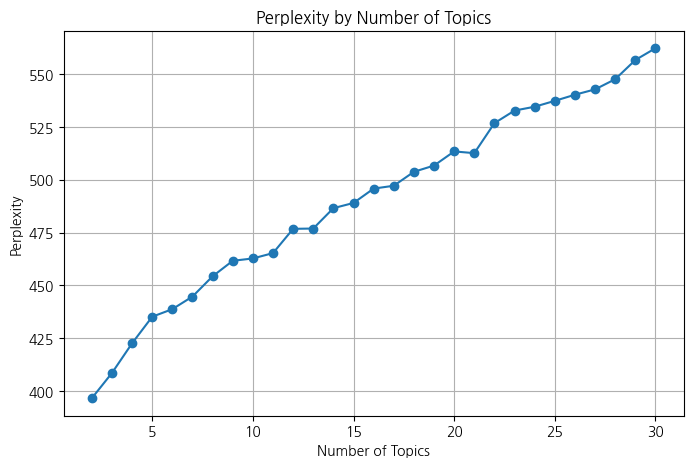

In [10]:
total_motivs = data['Processed Content'].reset_index(drop=True)

# 문서-단어 행렬 생성
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(total_motivs)

# 토픽 수별 Perplexity 계산
max_topics = 30
perplexities = []

for num_topics in range(2, max_topics + 1):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    perplexity = lda.perplexity(X)
    perplexities.append(perplexity)
    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}")

# Perplexity 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_topics + 1), perplexities, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity by Number of Topics")
plt.grid()
plt.show()

In [11]:
texts = data['Processed Content'].tolist()
texts = [str(x).split() if isinstance(x, str) else x for x in texts]

In [12]:
texts[0]

['군대', '소식', '와중', '군', '선임', '간부', '군무원']

Number of Topics: 2, Perplexity: 1301.0574293014588, Coherence: 0.5236927009704163
Number of Topics: 3, Perplexity: 1382.1761826174568, Coherence: 0.5204753537103556
Number of Topics: 4, Perplexity: 1442.6173536179401, Coherence: 0.5004333363405107
Number of Topics: 5, Perplexity: 1478.1410623189242, Coherence: 0.46214964935273917
Number of Topics: 6, Perplexity: 1521.2656828890563, Coherence: 0.4789911125862865
Number of Topics: 7, Perplexity: 1528.9429759386212, Coherence: 0.43866516116187276
Number of Topics: 8, Perplexity: 1563.4497046952613, Coherence: 0.4612022039178173
Number of Topics: 9, Perplexity: 1611.1899582917918, Coherence: 0.45636307925757563
Number of Topics: 10, Perplexity: 1646.9948156671057, Coherence: 0.469041704339958


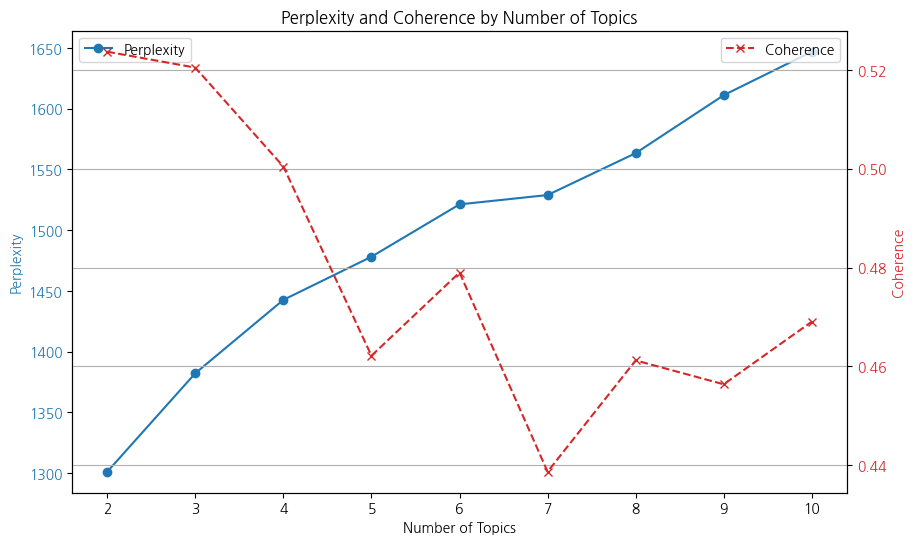

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]


vectorizer = CountVectorizer(analyzer=lambda x: x, tokenizer=lambda x: x, preprocessor=lambda x: x)
X = vectorizer.fit_transform(texts)


max_topics = 10  
perplexities = []
coherences = []


for num_topics in range(2, max_topics + 1):
  
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    
    # Perplexity 계산
    perplexity = lda.perplexity(X)
    perplexities.append(perplexity)
    
    # 각 주제당 top word
    topics = [
        [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
        for topic in lda.components_
    ]
    
    # Coherence 계산
    coherence_model = CoherenceModel(
        topics=topics, texts=texts, dictionary=id2word, coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherences.append(coherence)
    
    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}, Coherence: {coherence}")


fig, ax1 = plt.subplots(figsize=(10, 6))

# Perplexity
color = 'tab:blue'
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Perplexity", color=color)
ax1.plot(range(2, max_topics + 1), perplexities, marker='o', color=color, label="Perplexity")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Coherence
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Coherence", color=color)
ax2.plot(range(2, max_topics + 1), coherences, marker='x', linestyle='--', color=color, label="Coherence")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')


plt.title("Perplexity and Coherence by Number of Topics")
plt.grid()
plt.show()

In [44]:
print("Top words for Topic 1:", topics[0])
print("Top words for Topic 2:", topics[1])
print("Top words for Topic 3:", topics[2])
print("Top words for Topic 4:", topics[3])

Top words for Topic 1: ['친구', '사람', '여행', '공부', '일', '영어', '졸업', '문화', '꿈', '독일어']
Top words for Topic 2: ['여행', '사람', '수업', '공부', '도전', '물가', '문화', '복학', '군', '친구']
Top words for Topic 3: ['전공', '수업', '공부', '친구', '여행', '문화', '코로나', '국제', '영어', '사람']
Top words for Topic 4: ['여행', '친구', '졸업', '공부', '영어', '영어권', '문화', '로망', '영어실력', '실력']
